# バーチャルスクリーニング(LBVS)実習
ここでは[VSFlow](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00703-1) を利用したバーチャルスクリーニングを行います。

### 注意
- windows 環境の方はこの演習は cheminfotutorial1023/03_virtual_screeningをカレントディレクトリとして実行してください。
- 次の例にあるようにWindows環境の方はvsflowコマンドを直接打つのではなくpython vsflow ...というように打って実行してください

##　データベースの構築

今回はPDBリガンドを使いますので、ターミナルより以下のコマンドを実行してください


```
# Linux / Mac
$ vsflow preparedb --download pdb 　# ligand expoからデータ取得

# Windows
$ python vsflow preparedb --download pdb 　# ligand expoからデータ取得

```

他にもvsflow preparedbにはいくつかのDB構築オプションが用意されています。

```
# Linux / Mac
$ vsflow preparedb --download chembl # chembl ftpからVer28をDL（少し古いので注意）
$ vsflow preparedb -i yourdata.sdf

# Windows
$ python vsflow preparedb --download chembl # chembl ftpからVer28をDL（少し古いので注意）
$ python vsflow preparedb -i yourdata.sdf

```



## Substructure Search
はじめに部分構造検索を行います。


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.TemplateAlign import AlignMolToTemplate2D
from rdkit.Chem import rdDepictor
import pandas as pd
IPythonConsole.drawOptions.comicMode = True
rdDepictor.SetPreferCoordGen(True)
#IPythonConsole.InteractiveRenderer.setEnabled()
import subprocess

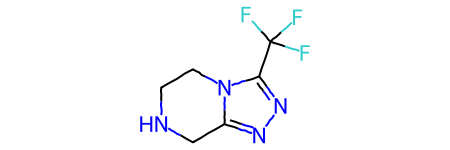

In [3]:
query = "N3Cc2nnc(n2CC3)C(F)(F)F"
qm = Chem.MolFromSmiles(query)
rdDepictor.Compute2DCoords(qm)
pc = qm.GetConformer(0)
qm

### JupyterNotebook上でvsflowコマンドを実行する
VSFLOWはCLI ToolのためJupyterからは利用しないですが、今回は出力データの確認をJupyter上で行うためSubprocessを利用しコマンドを実行します。

以下のセルで実行されるコードは以下のコマンドと等価です。

```bash
$ vsflow substructure -smi "N3Cc2nnc(n2CC3)C(F)(F)F" -d ./pdb_ligs.vsdb
```

In [4]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb'
])
# Windows 
"""
subprocess.call(
[   'python',
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb'
])

"""


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:20:26
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.04768 seconds
Generating output file(s) ...
4 matches found
Finished: 10/15/2023, 12:20:27
Finished in 1.04972 seconds


"\nsubprocess.call(\n[   'python',\n    'vsflow',\n    'substructure',\n    '-smi',\n    query,\n    '-d',\n    './pdb_ligs.vsdb'\n])\n\n"

4件ヒットしたので、構造をみてみましょう

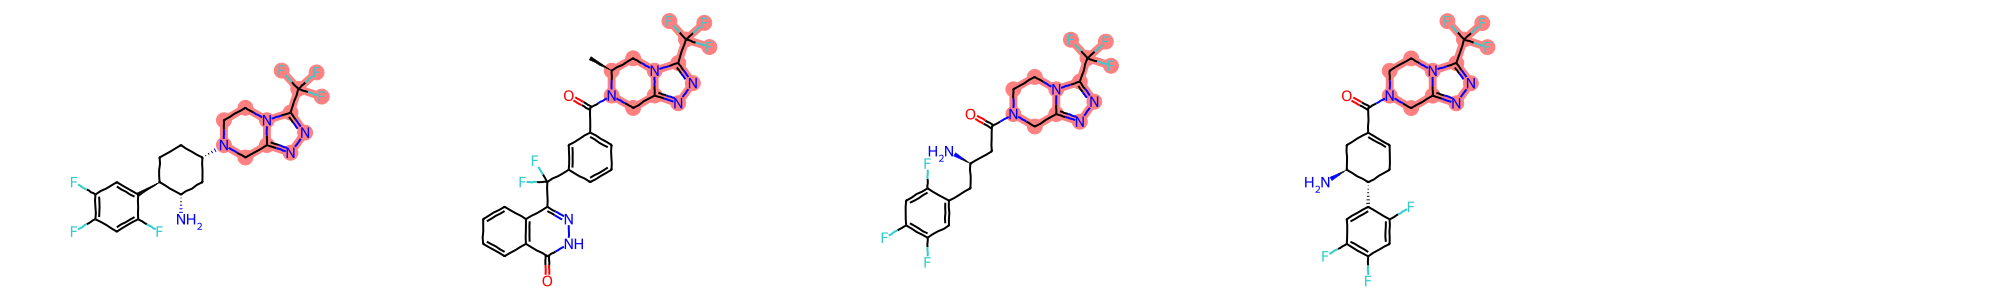

In [5]:
hits = Chem.SDMolSupplier('./substructure.sdf')
mols = [m for m in hits]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm)
    # GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    rdDepictor.GenerateDepictionMatching2DStructure(m, qm, confId=0)
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5, subImgSize=(400,300))

### pdf option
- --pdfオプションを付与することで部分構造マッチ部分をハイライトしたサマリーをPDFとして出力することが可能です。
- -o の引数としてxlsxファイルを指定することでエクセルへの出力ができます。WindwosPCではエクセルを利用するツールも多いので便利なオプションかもしれません。

In [6]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure.xlsx',
    '--pdf',
    '-p'
])

# Windows
"""
subprocess.call(
[   'python',
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure.xlsx',
    '--pdf',
    '-p'
])
"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:21:05
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.0586 seconds
Generating output file(s) ...
4 matches found
Generating PDF file(s) ...
Finished: 10/15/2023, 12:21:06
Finished in 1.18177 seconds


"\nsubprocess.call(\n[   'python',\n    'vsflow',\n    'substructure',\n    '-smi',\n    query,\n    '-d',\n    './pdb_ligs.vsdb',\n    '-o',\n    './substructure.xlsx',\n    '--pdf',\n    '-p'\n])\n"

pdfファイルとエクセルファイルが出力されていますので、pdfのほうは各自で開いて確認してください。excelファイルはpandasで確認してみましょう。

In [7]:
df = pd.read_excel('./substructure.xlsx')
df

,Smiles,ligand_id,name,QuerySmiles,MW (g/mol),cLogP,TPSA (A²),HDon,HAcc,RotBonds,AromRings,HetAromRings
0,N[C@H]1C[C@@H](N2CCn3c(nnc3C(F)(F)F)C2)CC[C@@H...,417,"(1s,2r,5s)-5-[3-(trifluoromethyl)-5,6-dihydro[...",N3Cc2nnc(n2CC3)C(F)(F)F,419.37,3.19,59.97,1,5,2,2,1
1,C[C@H]1Cn2c(nnc2C(F)(F)F)CN1C(=O)c1cccc(C(F)(F...,5N8,4-[bis(fluoranyl)-[3-[[(6~{s})-6-methyl-3-(tri...,N3Cc2nnc(n2CC3)C(F)(F)F,504.42,3.72,96.77,1,6,3,4,2
2,N[C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1cc(F)...,715,"(2r)-4-oxo-4-[3-(trifluoromethyl)-5,6-dihydro[...",N3Cc2nnc(n2CC3)C(F)(F)F,407.32,2.02,77.04,1,5,4,2,1
3,N[C@H]1CC(C(=O)N2CCn3c(nnc3C(F)(F)F)C2)=CC[C@@...,KIQ,"(1s,6r)-3-{[3-(trifluoromethyl)-5,6-dihydro[1,...",N3Cc2nnc(n2CC3)C(F)(F)F,445.37,2.89,77.04,1,5,2,2,1


続いて別の部分構造でも検索してみます。

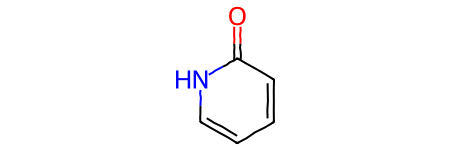

In [8]:
query2 = "C1=CC=CNC(=O)1"
Chem.MolFromSmiles(query2)

In [9]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure_2.sdf'
])

# Windows
"""
subprocess.call(
[
    'python',
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure_2.sdf'
])

"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:22:13
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.18197 seconds
Generating output file(s) ...
735 matches found
Finished: 10/15/2023, 12:22:15
Finished in 1.47983 seconds


"\nsubprocess.call(\n[\n    'python',\n    'vsflow',\n    'substructure',\n    '-smi',\n    query2,\n    '-d',\n    './pdb_ligs.vsdb',\n    '-o',\n    './substructure_2.sdf'\n])\n\n"

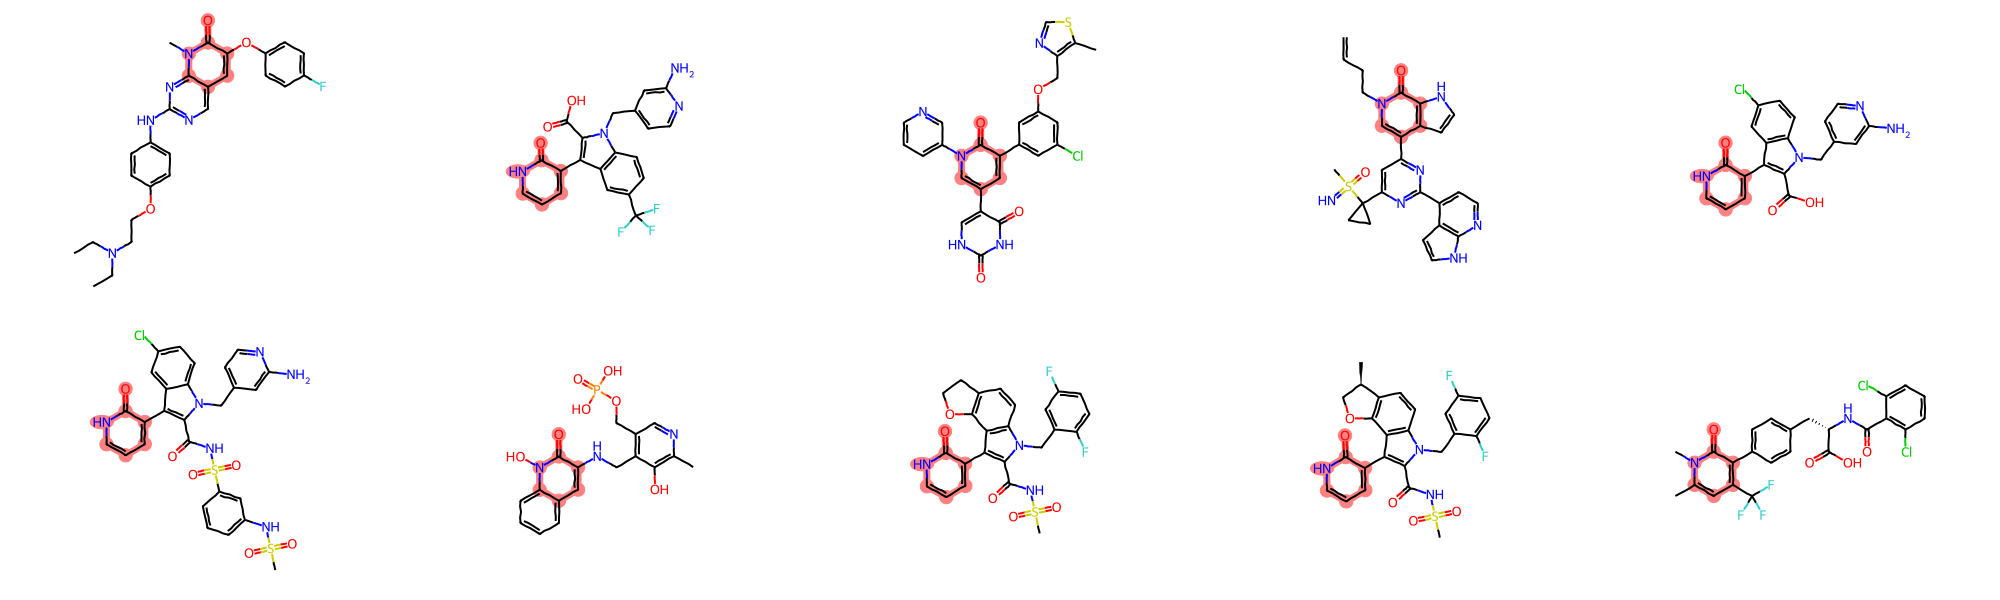

In [10]:
hits2 = Chem.SDMolSupplier('./substructure_2.sdf')
qm2 = Chem.MolFromSmiles(query2)
rdDepictor.Compute2DCoords(qm2)
mols = [m for m in hits2][:10]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm2)
    #GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    rdDepictor.GenerateDepictionMatching2DStructure(m, qm2)
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5, subImgSize=(400,300))

##　部分構造検索におけるTautomerの扱い
vsflowではmode オプションを付与することでTautomerを加味した検索の実施が可能です。

- -m all_tautsとするとデフォルトで最大100件までクエリ構造からTautomerを発生し検索をかけます。
- -m can_tautは各ツール毎に異なるTautmerの表現揺れに対する対策として有用です。

In [11]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-m',
    'all_tauts',
    '-o',
    './substructure_3.sdf'
])

# Windows
"""
subprocess.call(
[
    'python',
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-m',
    'all_tauts',
    '-o',
    './substructure_3.sdf'
])

"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:23:00
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.40046 seconds
Generating output file(s) ...
1075 matches found
Finished: 10/15/2023, 12:23:02
Finished in 1.85814 seconds


"\nsubprocess.call(\n[\n    'python',\n    'vsflow',\n    'substructure',\n    '-smi',\n    query2,\n    '-d',\n    './pdb_ligs.vsdb',\n    '-m',\n    'all_tauts',\n    '-o',\n    './substructure_3.sdf'\n])\n\n"

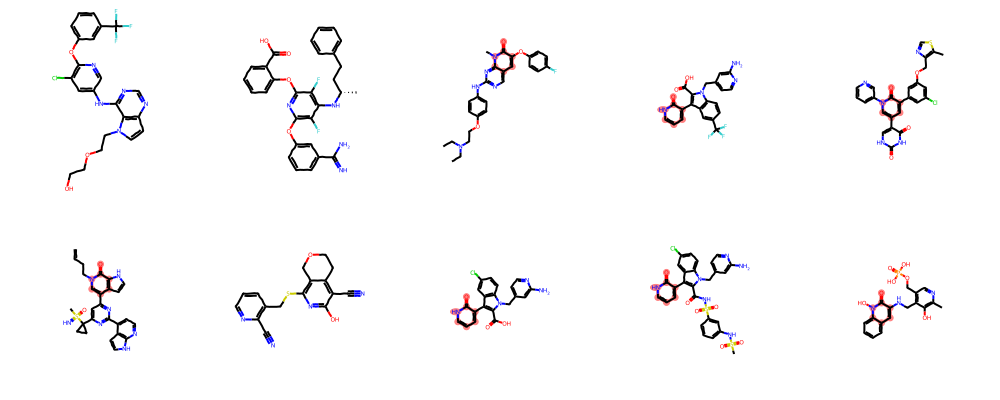

In [12]:
hits3 = Chem.SDMolSupplier('./substructure_3.sdf')
qm2 = Chem.MolFromSmiles(query2)
rdDepictor.Compute2DCoords(qm2)
mols = [m for m in hits3][:10]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm2)
    #GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    try:
        rdDepictor.GenerateDepictionMatching2DStructure(m, qm2)
    except:
        pass
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5)

Tautomerを考慮しない場合のヒット数が735件であるのに対し、考慮した場合は1075件と大幅に増えていることがわかると思います。

上記の構造表記の例では2ヒドロキシピリジンも部分構造としてヒットしたので構造に含まれています。

# Similarity Search
### 次は類似構造検索を実施してみます。
- [ref](https://github.com/czodrowskilab/VSFlow/wiki/4-Fingerprint-Similarity)
- 類似構造検索をするコマンドはvsflow fpsimです。
- 下の例では一つしかクエリを与えていませんが、複数のクエリを一回の検索で投げることも可能です。
- -tオプションでヒットの上位何件を出力するかをしてきます。デフォルトは10なので結果は10件帰ってきます。
- fingeprintは、fcfp, ecfp, rdit, ap, tt, maccsの中から任意のものを利用できます。デフォルトはfcfpに設定されています。

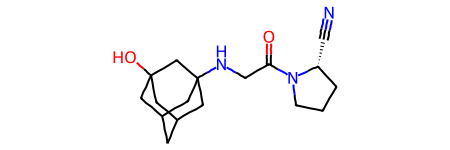

In [13]:
query = 'N#C[C@H]4N(C(=O)CNC13CC2CC(C1)CC(O)(C2)C3)CCC4'
Chem.MolFromSmiles(query)

In [14]:
subprocess.call(
[
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './sim_search_res.sdf'
])

# Windows
"""
subprocess.call(
[
    'python',
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './sim_search_res.sdf'
])

"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:23:40
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query input ...
Calculating fingerprints ...
Finished fingerprint generation in 9.09921 seconds
Calculating similarities ...
Finished calculating similarities in 0.14688 seconds
Writing 10 molecules to output file(s)
Generating output file(s) ...
Finished: 10/15/2023, 12:23:50
Finished in 10.51269 seconds


"\nsubprocess.call(\n[\n    'python',\n    'vsflow',\n    'fpsim',\n    '-smi',\n    query,\n    '-d',\n    './pdb_ligs.vsdb',\n    '-o',\n    './sim_search_res.sdf'\n])\n\n"

In [15]:
sim_hits = [m for m in Chem.SDMolSupplier('./sim_search_res.sdf')]

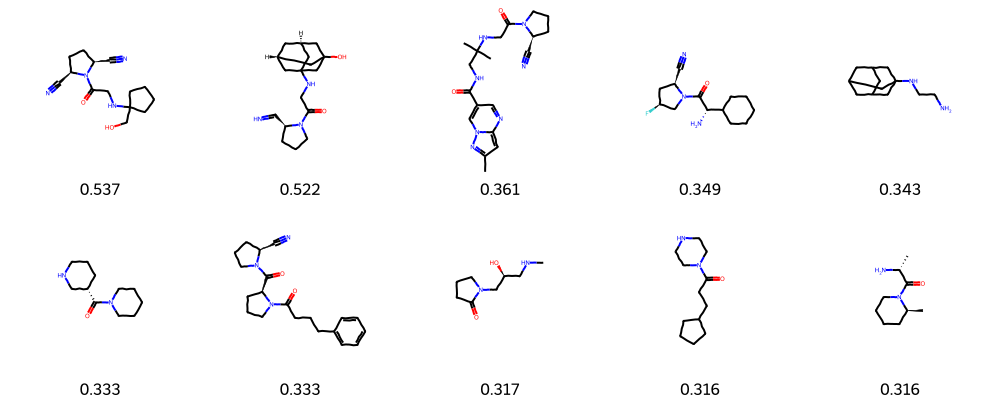

In [16]:
Draw.MolsToGridImage(sim_hits, molsPerRow=5,
                    legends=[f"{float(m.GetProp('TanimotoSimilarity')):.3f}" for m in sim_hits])

### オプションについて
部分構造検索のときと同様にPDFに結果を出力できます。

In [17]:
subprocess.call(
[
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '--pdf',
    '-o',
    './sim_search_res'
])

# Windows
"""
subprocess.call(
[
    'python',
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '--pdf',
    '-o',
    './sim_search_res'
])
"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:24:17
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query input ...
Calculating fingerprints ...
Finished fingerprint generation in 8.54838 seconds
Calculating similarities ...
Finished calculating similarities in 0.13841 seconds
Writing 10 molecules to output file(s)
Generating output file(s) ...
Generating PDF file(s) ...
Finished: 10/15/2023, 12:24:27
Finished in 10.12425 seconds


"\nsubprocess.call(\n[\n    'python',\n    'vsflow',\n    'fpsim',\n    '-smi',\n    query,\n    '-d',\n    './pdb_ligs.vsdb',\n    '--pdf',\n    '-o',\n    './sim_search_res'\n])\n"

# Shape-based Screening
### [分子形状に着目したスクリーニング](https://github.com/czodrowskilab/VSFlow/wiki/5-Shape-Screening)

VSFlowには、クエリー分子とデータベース分子間の形状の類似性に基づいて化合物データベースをスクリーニングするオプションが含まれています。これを利用するためには、3次元情報を持つ分子からなるデータベースを用意する必要があります。ただし、クエリー分子は2Dでも3DでもOKです。クエリーが2Dの場合、VSFlowは各クエリー分子について、エネルギー最小化された3Dコンフォーマーを1つ（必要であれば複数）生成します。
データベース構築の際には"prepareb"オプションによりを3Dデータベースを作成することができます。

実際には以下のようなオプションが指定できます。
 - -o 出力ファイルの名前 
 - -np 実行する際に利用するコア数
 - -t Top何個のヒットを返すか
 - -s ランキングに利用するスコアの指定 (shapre, pharmacophore, combo)
 - --nconfs クエリが2Dだった場合配座を何個発生し探索するか（デフォルトは100）
 - --pymol Pymolセッションファイルを生成する

以下のコマンドはShape Screenを8並列で行う例です。

In [18]:
# Subprocessではうまく動作しないので、ここはコマンドで実行します。
!vsflow shape -i XED.sdf -d ../VSFlow/examples/fda_multiple_confs.vsdb -o XED_shapesim --pymol -np 8

"""
# Windows
# Subprocessではうまく動作しないので、ここはコマンドで実行します。
!python vsflow shape -i XED.sdf -d ../VSFlow/examples/fda_multiple_confs.vsdb -o XED_shapesim --pymol -np 8
"""

**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/15/2023, 12:24:56
Running in parallel mode on 8 threads
Reading database ...
../VSFlow/examples/fda_multiple_confs.vsdb could not be opened. Please make sure you specified the correct path

'\n# Windows\n# Subprocessではうまく動作しないので、ここはコマンドで実行します。\n!python vsflow shape -i XED.sdf -d ../VSFlow/examples/fda_multiple_confs.vsdb -o XED_shapesim --pymol -np 8\n'

## 演習
1-1で作成したデータ正規化をpubchemかzincのデータを前処理してバーチャルスクリーニングを実施するお題があるとよいです。